# Comparing Impacts of Missing Data on Uniform and Lognormal Regressors

In [123]:
from generator import *
from shredder import *
from fitter import *
from fixer import *
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
#np.random.seed(10)


# Generating regression data


In [141]:
# Declare that there should be one X uniformly distributed between 0 and 100 with a coefficient of 5.


x1_lognorm_clean_fit_data, x1_lognorm_test_data = generate_ind_model(
                                                        1, 
                                                        [x_def_helper('lognormal', coeff=10, mean=1.57, sigma=1)],
                                                        intercept=10, 
                                                        n=200, 
                                                        noise_factor=.05
                                                    )

x1_uniform_clean_fit_data, x1_uniform_test_data = generate_ind_model(
                                                        1, 
                                                        [x_def_helper('uniform', coeff=6, low=0, high=100)],
                                                        intercept=10, 
                                                        n=200, 
                                                        noise_factor=.1
                                                    )
print(x1_lognorm_clean_fit_data['y'].std())
print(x1_uniform_clean_fit_data['y'].std())

77.89366929833781
178.41862678824657


### Initial EDA/Modeling

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x115916cc0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x116d00da0>]], dtype=object)

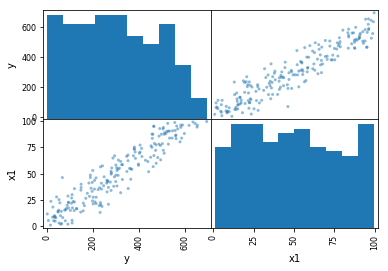

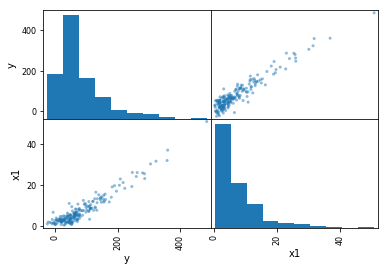

In [142]:
scatter_matrix(x1_uniform_clean_fit_data[['y', 'x1']])
scatter_matrix(x1_lognorm_clean_fit_data[['y', 'x1']])

### Part 1: Randomly Removing Values of `x1` and Dropping Respective Rows 
This is now performed for both the uniform and lognormal case

In [143]:
def run(fit_data, test_data, action_type, incr=.05,iters=50):
    run_results = []
    # Begin replication loop
    for i in range(iters):
        # Begin percent range loop
        for pct in np.arange(0, 1, incr):

            # Make a copy of the dataset so that we do not contaminate the memory
            wrecked_data = fit_data.copy(deep=True)
            
            # Shred the data unless pct == 0
            if pct != 0:
                # Specify that we are shredding x1
                uniform_shred_cols(['x1'], pct, wrecked_data)

                if action_type == 'drop':
                    fixed_data = wrecked_data.dropna()
                elif action_type == 'fix':
                    fixed_data = fix_cols({'x1': 'mean'}, wrecked_data)
                else:
                    raise ValueError("Invalid action_type: %s" % action_type)
            else:
                fixed_data = wrecked_data
                    
            # Fit the model
            w_fitted, w_metrics, = fit_lm(fixed_data, test_data)
            
            # Collect some results
            run_results.append((pct,
                                  w_fitted.nobs,
                                  w_metrics['r2'],
                                  w_metrics['r2_adj'],
                                  w_metrics['bic'],
                                  w_metrics['beta_ci']['x1']['range'],
                                  w_metrics['beta_ci']['x1']['low'],
                                  w_metrics['beta_ci']['x1']['high'],
                                  w_metrics['r2_pred'],
                                  w_metrics['mse_pred']))



    results = pd.DataFrame(run_results, columns=['pct_missing', 
                                                  'nobs', 
                                                  'r2', 
                                                  'r2_adj',
                                                  'bic', 
                                                  'beta_x1_rng', 
                                                  'beta_x1_low',
                                                  'beta_x1_high',
                                                  'r2_pred', 
                                                  'mse'])

    results = results.groupby('pct_missing').mean()
    results.loc[:, 'action_type'] = action_type
    
    return results

In [127]:
x1_lognorm_results = {'fix': run(x1_lognorm_clean_fit_data, x1_lognorm_test_data, 'fix', iters=50),
                      'drop': run(x1_lognorm_clean_fit_data, x1_lognorm_test_data, 'drop', iters=50)
                     }
# x1_uniform_results = {'fix': run(x1_uniform_clean_fit_data, x1_uniform_test_data, 'fix', iters=10),
#                       'drop': run(x1_uniform_clean_fit_data, x1_uniform_test_data, 'drop', iters=10)
#                      }

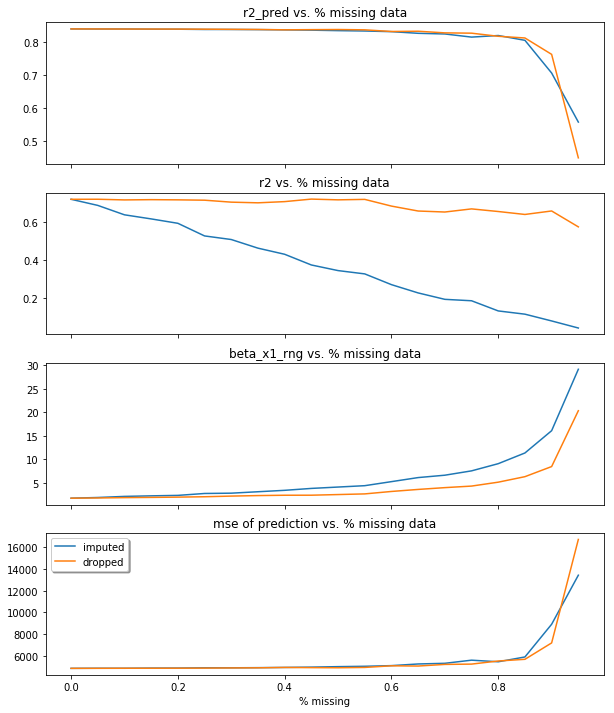

In [128]:
x1_uniform_results = x1_lognorm_results
f, axarr = plt.subplots(4, sharex=True, figsize=(10,12))
axarr[0].plot(x1_uniform_results['fix'][['r2_pred']], label='imputed')
axarr[0].plot(x1_uniform_results['drop'][['r2_pred']], label='dropped')
axarr[0].set_title('r2_pred vs. % missing data')

axarr[1].plot(x1_uniform_results['fix'][['r2']], label='imputed')
axarr[1].plot(x1_uniform_results['drop'][['r2']], label='dropped')
axarr[1].set_title('r2 vs. % missing data')

axarr[2].plot(x1_uniform_results['fix'][['beta_x1_rng']], label='imputed')
axarr[2].plot(x1_uniform_results['drop'][['beta_x1_rng']], label='dropped')
axarr[2].set_title('beta_x1_rng vs. % missing data')

axarr[3].plot(x1_uniform_results['fix'][['mse']], label='imputed')
axarr[3].plot(x1_uniform_results['drop'][['mse']], label='dropped')
axarr[3].set_title('mse of prediction vs. % missing data')


axarr[3].set_xlabel('% missing')
plt.legend(shadow=True, fancybox=True)

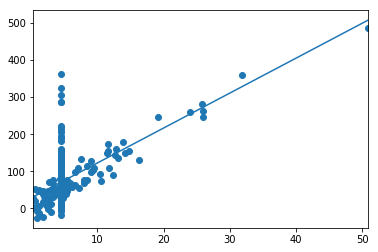

In [146]:
wrecked_data = x1_lognorm_clean_fit_data.copy(deep=True)
wrecked_data = uniform_shred_cols(['x1'], .5, wrecked_data)

fixed_data = fix_cols({'x1': 'median'}, wrecked_data)
ex_fitted, ex_metrics, = fit_lm(fixed_data, x1_uniform_test_data)


fig = sm.graphics.abline_plot(model_results=ex_fitted)
ax = fig.axes[0]
ax.scatter(fixed_data['x1'], fixed_data['y'])

## Lognormal and Uniform Head to Head

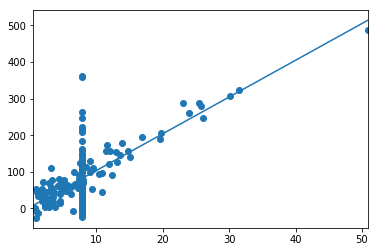

In [145]:
wrecked_data = x1_lognorm_clean_fit_data.copy(deep=True)
wrecked_data = uniform_shred_cols(['x1'], .5, wrecked_data)

fixed_data = fix_cols({'x1': 'mean'}, wrecked_data)
ex_fitted, ex_metrics, = fit_lm(fixed_data, x1_uniform_test_data)

fig = sm.graphics.abline_plot(model_results=ex_fitted)
ax = fig.axes[0]
ax.scatter(fixed_data['x1'], fixed_data['y'])

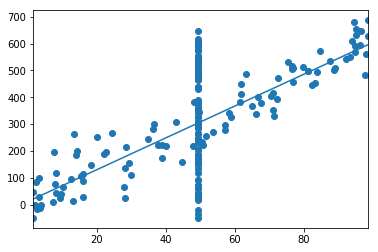

In [138]:
wrecked_data = x1_uniform_clean_fit_data.copy(deep=True)
wrecked_data = uniform_shred_cols(['x1'], .5, wrecked_data)

fixed_data = fix_cols({'x1': 'mean'}, wrecked_data)
ex_fitted, ex_metrics, = fit_lm(fixed_data, x1_uniform_test_data)


fig = sm.graphics.abline_plot(model_results=ex_fitted)
ax = fig.axes[0]
ax.scatter(fixed_data['x1'], fixed_data['y'])